https://medium.com/swlh/web-scraping-python-requests-and-beautifulsoup-45d5f48f5a1

https://sparkbyexamples.com/spark/spark-read-text-file-rdd-dataframe/

https://medium.com/swlh/text2sql-in-spark-nlp-converting-natural-language-questions-to-sql-queries-on-scale-6ae9a9061d74

https://www.oreilly.com/library/view/learning-spark-2nd/9781492050032/ch04.html

https://www.computerhope.com/issues/ch001721.htm

In [1]:
#!python -m pip install html2text

In [2]:
#!python -m pip install mistletoe

https://github.com/webrecorder/warcio

In [3]:
#!pip install warcio

In [4]:
#!python -m pip install cdx_toolkit

In [5]:
#!pip install -U gensim

In [6]:
#!pip install keras

In [7]:
#!pip install tensorflow

In [8]:
#%load_ext autoreload
#%autoreload 2

Run the cell below to import everything necessary for this analysis.

In [9]:
import json
import sys
import os.path
import re
import logging
import pandas as pd
import requests
import warcio
import mistletoe
import cdx_toolkit
import zlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import string
import warnings
warnings.filterwarnings('ignore')

from warcio import ArchiveIterator
from contextlib import closing
from html2text import HTML2Text
from bs4 import BeautifulSoup
from pathlib import Path
from IPython.display import HTML as HTML_raw, display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from nltk import word_tokenize, FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
np.random.seed(0)

In this analysis, we'll start by creating our own word embeddings by making use of the `Word2Vec` model. Then, we'll move onto building neural networks that make use of Embedding Layers to accomplish the same end-goal, but directly in our model.

* Train a Word2Vec model and transform words into vectors
* Obtain most similar words by using methods associated with word vectors

The easiest way to make use of `Word2Vec` is to import it from the `Gensim` Library. This model contains a full implementation of Word2Vec, which you can use to begin training immediately.

# Our corpus

In this analysis, we'll be working with alomost 100k different documents, each containing one single job AD.

These job AD plain text files are contained within the `\c\Users\renjm\Job-Posting-Big-Data\ana\dat\100k_jobADs` subdirectory, contained within the same folder as this analysis. Each job AD is stored in a single file, with files ranging from `1_2021JAN_jobAD.txt` to `99422_2021JAN_jobAD.txt`.

To make it easy to read in all of the documents, use a list comprehension to create a list containing the name of every single job AD plain text file below.

In [10]:
filesList = []
n_0 = 1
n_1 = 100000
for i in range(n_0, n_1):
    filepath = './dat/100k_jobADs/'+str(i)+'_2021JAN_jobAD.txt'
    if (os.path.exists(filepath)):
        filesList.append(str(i)+'_2021JAN_jobAD.txt')

#print(filesList)

## Splitting descriptions associated with qualification/certification from one Job ad text

In [11]:
statesList = ["United States of America","USA","AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS",
              "KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA",
              "RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY","DC","GU","MH","MP","PR","VI","Alabama","Alaska",
              "Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho",
              "Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
              "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","Hampshire","Jersey","Mexico","York",
              "Carolina","Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode","Tennessee","Texas","Utah","Vermone",
              "Virginia","Washington","Wisconsin","Wyoming"]
itList = ["Engineer","Scientist","Developer","Analyst","Operator"]
qaList = ["Qualification","Qualifications","Certification","Certifications"]
euList = ["United Kingdom","UK","EU"]

In [12]:
def qa_text(jobad):

    my_jobad = []
    my_qaget = []
    lineCounter = 0
    
    for line in jobad:
        if line != ' \n':
            lineCounter += 1
            my_jobad.append(line)
        else:
            continue
        
        for qa in qaList:
            if qa in line:
                my_qaget.append(lineCounter)
    
    return my_jobad, my_qaget     

In [13]:
def qa_para(my_jobad, my_qaget, num=5):
    test_jobad = []
    for i in range(0, len(my_jobad)):
        for j in list(set(my_qaget)):
            if i == j:
                #for k in range(len(my_jobad)//2-5, 0, -1):
                for k in range(1, 0, -1):
                    try:
                        test_jobad.append(my_jobad[i-k])
                    except Exception as e:
                        print(e,k)
                #for k in range(0, len(my_jobad)//2-5, 1):
                if len(my_jobad) > (i + num):
                    for k in range(0, num, 1):
                        try:
                            test_jobad.append(my_jobad[i+k])
                        except Exception as e:
                            print(e,k)
                else:
                    for k in range(0, (len(my_jobad) - i), 1):
                        try:
                            test_jobad.append(my_jobad[i+k])
                        except Exception as e:
                            print(e,k)
                
    return test_jobad

## Cleaning and Preprocessing Our Text Data

Now that we have our data, the fun part begins. We'll need to begin by preprocessing and cleaning our text data. As we've seen, preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing and cleaning we need to do. Before we can begin cleaning and preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

These are all questions that we'll need to think about pretty much anytime we begin working with text data.

Let's get right into it. We'll start by getting a list of all of the english stopwords, and concatenating them with a list of all the punctuation.

## Removing Stop Words and Punctuation

`Stop Words` don't contain any interesting information, and essentially just act as the "connective tissue" between the words that really matter in any text. Let's try removing the stopwords and punctuation, and then creating another frequency distribution that contains only the important words.

We've already imported the `stopwords` module. We can access all of the stopwords using the `stopwords.words()` method -- however, we don't want to use the whole thing, as this contains all stopwords in every language supported by NLTK. We don't need to check for and remove any Finnish or Japanese stop words, as this text is in English. To avoid unnecessarily long runtimes, we'll just use the English subset of stopwords by passing in the parameter `"english"` into `stopwords.words()`.

In the cell below:

* Get all the `'english'` stopwords from `stopwords.words()` and store them in the appropriate variable below. They will be stored as a list, by default
* We'll also want to remove all punctuation. Create a list version of `string.punctuation` and add it to our stopwords list
* Finally, we'll also remove numbers. Create a list that contains numbers 0-9 (as strings!), and add this to the stopwords list as well
* Use another list comprehension to get words out of `jobad_tokens` as long as they are not in `stopwords_list`

In [14]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Tokenizing our Data

Before we can create a bag of words or vectorize each document, we need to clean it up and split each job AD into an array of individual words. Computers are very particular about strings. If we tokenized our data in its current state, we would run into the following problems:

* Counting things that aren't actually words. 
* Punctuation and capitalization would mess up our word counts. To the Python interpreter, `love`, `Love`, `Love?`, and `Love\n` are all unique words, and would all be counted separately. We need to remove punctuation and capitalization, so that all words will be counted correctly.

Tokenization is pretty tedious if we handle it manually, and would probably make use of `regular expressions` (**regex**). In order to keep this lab moving, we'll use a library function to clean and tokenize our data so that we can move onto vectorization.

Tokenization is a required task for just about any Natural Language Processing (NLP) task, so great industry-standard tools exist to tokenize things for us, so that we can spend our time on more important tasks without getting bogged down hunting every special symbol or punctuation in a massive dataset. For this analysis, we'll make use of the tokenizer in the amazing `nltk` library, which is short for *Natural Language Tool Kit*.

**NOTE**: `NLTK` requires extra installation methods to be run the first time certain methods are used. If `nltk` throws you an error about needing to install additional packages, follow the instructions in the error message to install the dependencies, and then re-run the cell.

Before we tokenize our job AD plain text files, we'll do only a small manual bit of cleaning. In the cell below, a function that allows us to make every word lowercase, remove newline characters `\n`, and all the following punctuation marks: `",.'?!"` is developed.

Furthermore, this function that not only takes in job AD plain text files having erratic symbols removed but also joins all of the lines into a single string. To sum up, the function, `tokenize_jobAD()`, is utilized to get a fully tokenized version of the job AD. We can test this function on `jobad` to ensure that the function works.

In [15]:
#def process_article(article):
#    tokens = nltk.word_tokenize(article)
#    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
#    return stopwords_removed    

In [16]:
#processed_data = list(map(process_article, data))

In [17]:
def tokenize_jobAD(jobad):
    
    subs = [('.',''),("'",""),('"',''),(',',''),('?',''),('!',''),('\n',''),('\t',''),('\r',''),('|',''),('/',' '),
            ('-',''),('(c)',''),('*',''),('(',''),(')',''),('&',''),(':',''),(';',''),('[',''),(']',''),("\\",""),
            ('â„¢',''),('%',''),('â£',''),('Â£0',''),('Â£',''),('>',''),('<',''),('=',''),('_',''),('__',''),('“',''),
            ('’',''),('–',''),('”',''),('—',''),('+',''),('none',''),('…',''),('•',''),('#',''),('®',''),('â',''),
            ('ufeff',''),("xad",""),("u200e",""),("©",''),("{",''),("}",''),("@",""),("~",""),('$',''),('�',''),('№',''),
            ("ⓒ",""),("●",""),("»",""),("‘",""),("☰",""),("✕",""),("`",""),("´",""),("‐",""),("″",""),("‐",""),
            ("──────────",""),("ue",""),('u200d',''),('u200b',''),("uf09a",""),("u200",""),("u2060",""),("uf0c9",""),
            ("uf400",""),("u200f",""),("uf09a",""),("u200c",""),("uf0a7",""),("uf099",""),("u2066",""),("ue614",""),
            ("uf0fa",""),("uf071",""),("ue61b",""),("uf08c",""),("uf0a8",""),("uf0b7",""),("u202a",""),("ue5d2",""),
            ("ue92b",""),("ue61c",""),("ue613",""),("x86",""),("x96",""),("x92",""),("x7f",""),("x95",""),("x80",""),
            ("x99",""),("x9d",""),("x9c",""),("x97","")]
    pattern = r'[0-9]'
    
    cleaned_jobad = []
    for line in jobad:
        line = re.sub(pattern, '', line)
        for old, new in subs:
            line = line.replace(old, new).lower()
        cleaned_jobad.append(line)

    tokenized_jobad = ' '.join(cleaned_jobad).split()
    tokenized_jobad_no_stopped = [word for word in tokenized_jobad if word not in stopwords_list]
    
    return tokenized_jobad_no_stopped

Now that we can tokenize our job AD plain text file, we can move onto vectorization.

## Count Vectorization

Machine Learning algorithms don't understand strings. However, they do understand math, which means they understand vectors and matrices. By Vectorizing the text, we just convert the entire text into a vector, where each element in the vector represents a different word. The vector is the length of the entire vocabulary -- usually, every word that occurs in the English language, or at least every word that appears in our corpus. Any given sentence can then be represented as a vector where all the vector is 1 (or some other value) for each time that word appears in the sentence.

`Count Vectorization` allows us to represent a sentence as a vector, with each element in the vector corresponding to how many times that word is used. Notice that when we vectorize a sentence this way, we lose the order that the words were in. This is the `Bag of Words` approach

In the cell below, create a function that takes in a tokenized, cleaned job AD plain text file and returns a count vectorized representation of it as a Python dictionary (aka: *Sparse Representation*). Add in an optional parameter called vocab that defaults to None. This way, if we are using a vocabulary that contains words not seen in the song, we can still use this function by passing it into the vocab parameter.

In [18]:
def count_vectorize(jobad, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(jobad))
    
    jobad_dict = {i:0 for i in unique_words}
    
    for word in jobad:
        jobad_dict[word] += 1
    
    return jobad_dict

We've just successfully vectorized the first job AD plain text document! 

check this text job AD text file to ensure it contains any key word(s) in `qaList`

In [19]:
def qa_usa_Count(filename, tokenized_jobad):
    found_qa = False
    counter_notusa = 0
    counter_qa = 0
    counter_usa = 0
    qaINjobTarg = ""
    qaINjobList = []
    qaINusaDict = {}
    
    for eu in euList:
        if eu.lower() in tokenized_jobad.keys():
            counter_notusa += 1
            
    if counter_notusa == 0:
        for qa in qaList:
            if qa.lower() in tokenized_jobad.keys():
                counter_qa += 1
                found_qa = True
                qaINjobList.append(qa)
                qaINjobTarg = "Qualification"
        if found_qa == True:
            for usa in statesList:
                if usa.lower() in tokenized_jobad.keys():
                    counter_usa += 1
                    qaINusaDict.setdefault(filename, []).append(usa)
            for qa in qaINjobList:
                qaINusaDict.setdefault(filename, []).append(qa)
        else:
            qaINjobTarg = "NoQualification"
    else:
        qaINjobTarg = "NoQualification"
                
    return counter_qa, counter_usa, qaINusaDict, qaINjobTarg

## Getting a list of quality-related job ads

We loop over all job ad plain text files being downloaded from common crawl. require only quality-string-related job AD plain text files be further analyzed. 

* tokenize a corpus of words and identify the different choices to be made while parsing them

* use a count vectorization strategy to create a bag of words

* find quality-related strings from job ads

    - okPass : job AD is likely posted for any jobs avaialble in **North America only** (Canada might be included). in addition, we also require quality-related strings such as `qualification(s)` and `certification(s)`, be found 
    
    - okNotPass : cannot pass rwquirements as conditioned above

* get a word frequency distribution 

In [20]:
def get_list_of_qaJobAds(div1=3, div2=3):
    n_0 = 1
    n_1 = 100000
    docCounter = 0
    qaPassList = []
    okPassList = []
    okNotPassList = []
    okAllPassList = []
    qaTargetsDict = {}
    
    for i in range(n_0, n_1):
        qaNums_in_test_vectorized = 0
        usaNums_in_test_vectorized = 0
        filepath = './dat/100k_jobADs/'+str(i)+'_2021JAN_jobAD.txt'
        
        if (os.path.exists(filepath)):
            filename = filepath.replace('./dat/100k_jobADs/','').replace('.txt','')
            with open(filepath, encoding='utf-8', errors='ignore') as f:
                test_whole_jobad = f.readlines()
            docCounter += 1
            
            my_jobad, my_qaget = qa_text(test_whole_jobad) 
            test_jobad = qa_para(my_jobad, my_qaget)
            tokenized_test_jobad_no_stopped = tokenize_jobAD(test_jobad)
            test_vectorized_no_stopped = count_vectorize(tokenized_test_jobad_no_stopped)
            qaNums_in_test_vectorized, usaNums_in_test_vectorized, qaUSADict_in_test_vectorized_no_stopped, qaJobTarg_in_test_vectorized_no_stopped = qa_usa_Count(filename, test_vectorized_no_stopped) 
            qaTargetsDict[docCounter-1] = qaJobTarg_in_test_vectorized_no_stopped
            
            if (qaNums_in_test_vectorized > 0):
                if (i%div1 == 0):
                    qaPassList.append(qaUSADict_in_test_vectorized_no_stopped) 
                    okPassList.append(i)
                    okAllPassList.append(i)
            else:
                if (i%(div1*div2) == 0): # overall number compression of non-qualification-related files
                    okNotPassList.append(i)
                    okAllPassList.append(i)
        else:
            continue
                
    return qaPassList, qaTargetsDict, list(set(okPassList)), list(set(okNotPassList)), list(set(okAllPassList))

* okPass : found **at least one word string** from every single job AD plain text file in **both** `statesList` and `qaList` string lists, respectively

* okNotPass: doesn't satisfy the requirement above 

In [21]:
qaPassList, qaTargetsDict, okPassList, okNotPassList, okAllPassList = get_list_of_qaJobAds(1, 12) # div=1 means ALL

In [22]:
#print(okPassList)
#print(okNotPassList)

In [23]:
print(len(okPassList))
print(len(okNotPassList))
print(len(okAllPassList))

3230
3031
6261


In [24]:
print(len(qaTargetsDict))

39211


In [25]:
myList = []
okNotPassFile = './okNotPass.txt' 
with open(okNotPassFile, encoding='utf-8', errors='ignore') as f:
    myList = list(map(int, f.readlines()))
    
#print(myList)

In [26]:
okNewPassList = okPassList.copy()
for i in myList:
    if i in okNewPassList:
        okNewPassList.remove(i)
        
print(len(okNewPassList))

3224


## Processing All Job Ad Documents to Combine them

* Let's create another frequency distribution using `tokenized`, and then inspect the top 50 most common words, to see if removing stopwords and punctuation has helped.

* Now that we have a frequency distribution, we can easily answer Q7 about a list of selected job ad plain text files. Let's answer some basic questions about `QAjobad` below, before we move onto creating bigrams.

next, create an empty DataFrame called `QAjobads_df`. As we read in job ads and store and clean them, we'll store them in this DataFrame.

In [27]:
def get_data(okList, docs=10):
    
    doc_counter = 0
    # Iterate through list of filenames and read each in
    tokenized_all_docs = []
    tokenized_all_data = {}
    combined_all_text = {}
    targetqa_all_text = {}
    for fileNo in okList:
        filepath = './dat/100k_jobADs/'+str(fileNo)+'_2021JAN_jobAD.txt'
        if (os.path.exists(filepath)):
            if (docs > 0):
                doc_counter += 1
            with open(filepath, encoding='utf-8', errors='ignore') as f:
                raw_data = f.readlines()
        
        # split qualify-associated descriptions from raw text 
        #my_jobad, my_qaget = qa_text(raw_data) 
        #my_qa_jobad = qa_para(my_jobad, my_qaget)
        #combined_all_text[doc_counter-1] = my_qa_jobad
        combined_all_text[doc_counter-1] = raw_data
        if fileNo in okNewPassList:
            targetqa_all_text[doc_counter-1] = "Qualification"
        else:
            targetqa_all_text[doc_counter-1] = "NoQualification"
        
        # Clean and tokenize raw text
        #tokenized = tokenize_jobAD(my_qa_jobad)
        tokenized = tokenize_jobAD(raw_data)
        tokenized_all_docs += tokenized
        tokenized_all_data[doc_counter-1] = tokenized
        
        if (doc_counter > 0) & (doc_counter >= docs):
            break 
    
    return set(tokenized_all_docs), tokenized_all_docs, tokenized_all_data, combined_all_text, targetqa_all_text

In [28]:
tokenized_docs_set, tokenized_docs, tokenized_data, combined_text, targetqa_text = get_data(okAllPassList, 100000)
print('There are {} unique tokens in the dataset.'.format(len(tokenized_docs_set)))

There are 86014 unique tokens in the dataset.


In [29]:
tokenized_df = pd.Series(tokenized_data) 

In [30]:
tokenized_df[:5]

0    [caregiver, work, abroad, find, caregiver, wor...
1    [find, jobs, regions, career, advice, moving, ...
2    [workopolis, logo, job, title, keywords, city,...
3    [gleeson, group, home, login, register, login,...
4    [work, startup, startup, jobs, internships, up...
dtype: object

In [31]:
tokenized_df.shape

(6261,)

In [32]:
combined_df = pd.Series(combined_text) 

In [33]:
combined_df[:5]

0    [Caregiver Work Abroad \n,  Find caregiver wor...
1    [\n,  \n,  \n,  \n,  Find jobs Regions Career ...
2    [Workopolis Logo \n,  Job Title, Keywords \n, ...
3    [__ \n,  Gleeson Group  Home \n,  \n,  Login /...
4    [\n,  Work at a Startup Startup Jobs Internshi...
dtype: object

In [34]:
combined_df.shape

(6261,)

In [35]:
targetqa_df = pd.Series(targetqa_text) 

In [36]:
targetqa_df[:5]

0      Qualification
1    NoQualification
2      Qualification
3    NoQualification
4    NoQualification
dtype: object

In [37]:
targetqa_df.shape

(6261,)

In [38]:
print(tokenized_docs[:5])

['caregiver', 'work', 'abroad', 'find', 'caregiver']


In [39]:
print(tokenized_docs_set)

{'pours', 'dayside', 'lawrie', 'etorphine', 'presen', 'scramble', 'treat', 'anywayz', 'rapidgrowth', 'mediaotheroutsourcing', 'escrowofficer', 'aighteen', 'ringo', 'magento', 'mount', 'interventionsive', 'jeidccfafaefecfae', 'wga', 'eksctl', 'coronia', 'radiotelephone', 'civic', 'sowerecom', 'seiza', 'workstickers', 'stressful', 'orthodox', 'ambient', 'lorem', 'suku', 'aicpsenguciedu', 'nonrelated', 'alessandro', 'jobopportunitydurgapurajaipurrajasthanindiaedc', 'oldtime', 'andy', 'systemsaccountantenterpriseperformancemanagementepm', 'entities', 'nights', 'darfur', 'hugged', 'nah', 'aluminum', 'skillett', 'assertion', 'sen', 'kaun', 'feminisation', 'purchaser', 'detailsalthough', 'bpm', 'nicola', '😆', 'comapani', 'furnishings', 'pingbacks', 'wwwworkforrversandcamperscom', 'nsc', 'protomo', 'jaeggi', 'tanned', 'ultraviolet', 'onthai', 'nomination', 'heiss', 'tipper', 'paraxial', 'chrislabarthehttp', 'digitalmarketingassistant', 'onmuskoka', 'appsandwich', 'finnished', 'opposistion', 'n

# Loading A Pretrained GloVe Model

For this analysis, I'll be loading the pretrained weights from `GloVe` (short for `Global Vectors` for *Word Representation*) from the **[Stanford NLP Group](https://nlp.stanford.edu/projects/glove/)**. These are commonly accepted as some of the best pre-trained word vectors available, and they're open source, so you can get them for free! Even the smallest file is still **over 800 MB**, so I'll need to download this file manually.

Note that there are several different sizes of pretrained word vectors available for download from the page linked above -- for the purposes of this analysis, I'll only need to use the smallest one, which still contains pretrained word vectors for over 6 billion words and phrases! To download this file, follow the link above and select the file called `glove.6b.zip`. I'll be using the GloVe file containing **50-dimensional word vectors for 6 billion words**. Once I've downloaded the file, unzip it, and move the file glove.6B.50d.txt into the same directory as this Jupyter notebook.

For simplicity's sake, we can also start the download by clicking [this link](http://nlp.stanford.edu/data/glove.6B.zip).

## Getting the Total Vocabulary

Although the pretrained GloVe data contains vectors for 6 billion words and phrases, I don't need all of them. Instead, I only need the vectors for the words that appear in the dataset. If a word or phrase doesn't appear in the dataset, then there's no reason to waste memory storing the vector for that word or phrase.

This means that I need to start by computing the total vocabulary of the dataset. I can do this by adding every word in the dataset into a Python `set` object. This is easy, since I've already tokenized each job AD plain text file stored within `tokenized_all_docs`.

In the cell below, add every token from every job AD plain text file in `tokenized_all_docs` into a set, and store the set in the variable `tokenized_docs`.

HINT: Even though this takes a loop within a loop, you can still do this with a one-line list comprehension!

e.g.     tokenized_jobad_no_stopped = list(word for word in tokenized_jobad if word not in stopwords_list)

Now that I have gotten the total vocabulary, you can get the appropriate vectors out of the `GloVe` file.

In [40]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in tokenized_docs_set:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

After running the cell above, I now have all of the words and their corresponding vocabulary stored within the dictionary, `glove`, as key/value pairs.

Double-check that everything worked by getting the vector for a word from the glove dictionary. It's probably safe to assume that the word `'qualification'` and `'certification'` will be mentioned in at least one job AD plain text headline, so let's get the vector for it.

Get the vector for the word `'qualification'` and `'certification'` from `glove` in the cell below.

In [41]:
glove['qualification']

array([-0.93748 ,  0.67369 , -0.56793 ,  0.61793 , -0.11226 , -0.4005  ,
        0.67325 ,  0.51285 ,  0.53963 , -0.45018 ,  1.1848  , -0.60046 ,
       -0.41711 , -0.01562 ,  0.39255 ,  0.057022,  0.35431 , -0.12642 ,
       -0.96691 ,  0.010757, -0.22945 , -0.29754 ,  0.17842 ,  0.18349 ,
       -0.22542 , -0.34308 ,  0.33365 , -0.81665 , -0.67145 ,  0.15173 ,
        2.0083  ,  1.0823  , -1.0982  , -0.40341 ,  0.71605 ,  0.57125 ,
        0.90587 ,  1.4206  , -0.63919 , -1.3463  ,  0.24381 , -1.5122  ,
        0.6813  ,  0.57926 , -0.93749 , -0.37215 ,  1.0225  ,  0.9194  ,
        0.65065 , -0.63619 ], dtype=float32)

In [42]:
glove['certification']

array([-1.2703  , -0.049141, -0.31846 ,  0.12578 , -0.70724 , -0.30046 ,
       -0.34246 , -0.01362 ,  2.2553  ,  0.11646 ,  0.96442 ,  0.11594 ,
        0.67487 ,  0.048665, -0.11597 , -0.17221 , -0.27485 ,  0.14121 ,
        0.80188 , -0.85404 ,  0.095698,  0.16271 ,  0.094415, -0.55595 ,
       -0.56047 , -0.60275 , -0.42922 , -0.75957 , -0.51612 ,  0.24259 ,
        1.729   , -0.40629 , -1.7911  , -0.28975 ,  1.0076  , -0.22404 ,
        0.96096 ,  0.57199 ,  0.26382 , -0.68575 , -0.074433, -1.2159  ,
        0.64284 ,  0.42878 , -0.79632 , -0.63703 ,  0.28129 ,  1.1575  ,
        0.060524,  0.26284 ], dtype=float32)

Great—it worked! Now that I've gotten the word vectors for every word in the dataset, the next step is to combine all the vectors for a given headline into a `Mean Embedding` by finding the average of all the vectors in that job AD plain text.

## Creating Mean Word Embeddings

For this step, it's worth the extra effort to write my own `mean embedding vectorizer class`, so that I can make use of pipelines from scikit-learn. Using pipelines will save us time and make the code a bit cleaner.

The code for a mean embedding vectorizer class is included below, with comments explaining what each step is doing. 

In [43]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

## Using Pipelines

Since we've created a `mean vectorizer class`, I can pass this in as the first step in the pipeline, and then follow it up with the model we'll feed the data into for classification.

Run the cell below to create pipeline objects that make use of the mean embedding vectorizer that I built above.

In [44]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])
boost = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0))])

Now, we'll create a list that contains a tuple for each pipeline, where the first item in the tuple is a name, and the second item in the list is the actual pipeline object.

In [45]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr),
          ('Gradient Boosting', boost)]

We can then use the list I've created above, as well as the `cross_val_score()` function from scikit-learn to train all the models, and store their cross validation scores in an array.

In [46]:
qatarget_docs = pd.Series(qaTargetsDict) 

In [47]:
set(qatarget_docs.values)

{'NoQualification', 'Qualification'}

In [48]:
qatarget_docs.shape

(39211,)

Now that I've prepared the data, train my model and explore a bit!

## Training 3 Models : Random Forest, Support Vector Machine, Logistic Regression

In [49]:
scores = [(name, cross_val_score(model, tokenized_df, targetqa_df, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [50]:
scores

[('Random Forest', 0.8648783728213076),
 ('Support Vector Machine', 0.78373959059309),
 ('Logistic Regression', 0.7870946313429653),
 ('Gradient Boosting', 0.841559413593632)]

These scores are pretty high!

## Deep Learning With Word Embeddings

To end, we'll see how to use an **`Embedding Layer`** inside of a **`deep neural network`** to compute my own word embedding vectors on the fly, right inside the model!

`Using TensorFlow backend.`

Next, I'll convert the labels to a one-hot encoded format.

In [51]:
y = pd.get_dummies(targetqa_df).values
y

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [52]:
y.shape

(6261, 2)

Now, we'll preprocess the text data. To do this, I start from the step where I combine all job AD plain text files in the `Processing All Job Ad Documents` section. I'll then use Keras' preprocessing tools to tokenize each example, convert them to sequences, and then **pad the sequences so they're all the same length**.

Note how during the tokenization step, you set a parameter to tell the tokenizer to limit the overall vocabulary size to the 20000 most important words.

In [53]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(combined_df))
list_tokenized_headlines = tokenizer.texts_to_sequences(combined_df)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)
X_t.shape

(6261, 100)

Now, construct the neural network. In the embedding layer, you specify the size you want the word vectors to be, as well as the size of the embedding space itself. The embedding size you specified is 128, and the size of the embedding space is best as the size of the total vocabulary that we're using. Since you limited the vocabulary size to 20000, that's the size you choose for the embedding layer.

Once the data has passed through an embedding layer, you feed this data into an LSTM layer, followed by a Dense layer, followed by output layer. You also add some Dropout layers after each of these layers, to help fight overfitting.

Our output layer is a Dense layer with 41 neurons, which corresponds to the 41 possible classes in the labels. You set the activation function for this output layer to 'softmax', so that the network will output a vector of predictions, where each element's value corresponds to the percentage chance that the example is the class that corresponds to that element, and where the sum of all elements in the output vector is 1.

In [54]:
model = Sequential()

In [55]:
embedding_size = 128
model.add(Embedding(20000, embedding_size))
model.add(LSTM(50, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

Once you have designed the model, you still have to compile it, and provide important parameters such as the loss function to use ('categorical_crossentropy', since this is a multiclass classification problem), and the optimizer to use.

In [56]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

After compiling the model, you quickly check the summary of the model to see what the model looks like, and make sure the output shapes line up with what you expect.

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          35800     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

Finally, we can fit the model by passing in the data, the labels, and setting some other `hyperparameters` such as the `batch size`, the number of `epochs` to train for, and what percentage of the training data to use for validation data.

If trained for three epochs, you'll find the model achieves a validation accuracy around 89%.

Run the cell below for forty epochs. Note that this is a large network, so the training will take some time!

In [58]:
results_mlp = model.fit(X_t, y, epochs=4, batch_size=32, validation_split=0.2)

Epoch 1/4
157/157 [==============================] - 38s 186ms/step - loss: 0.6081 - accuracy: 0.6542 - val_loss: 0.3411 - val_accuracy: 0.8516
Epoch 2/4
157/157 [==============================] - 23s 150ms/step - loss: 0.3406 - accuracy: 0.8549 - val_loss: 0.3062 - val_accuracy: 0.8675
Epoch 3/4
157/157 [==============================] - 22s 143ms/step - loss: 0.2522 - accuracy: 0.8911 - val_loss: 0.3143 - val_accuracy: 0.8715
Epoch 4/4
157/157 [==============================] - 21s 133ms/step - loss: 0.2005 - accuracy: 0.9175 - val_loss: 0.3358 - val_accuracy: 0.8619


After two epochs, the model performs better than the shallow algorithms I just tried above. The LSTM Network was able to achieve a validation accuracy around 89% after only three epochs of training. 

It's common to add embedding layers in LSTM networks, because both are special tools most commonly used for text data. The embedding layer creates it's own vectors based on the language in the text data it trains on, and then passes that information on to the LSTM network, i.e. one sort of Recurrent Neural Network, one word at a time. 

## Visualizing our Loss and Accuracy Curves

Now, let's inspect the model's performance and see if we detect any overfitting or other issues. In the cell below, create two plots:

* The loss and val_loss over the training epochs
* The acc and val_acc over the training epochs

In [59]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

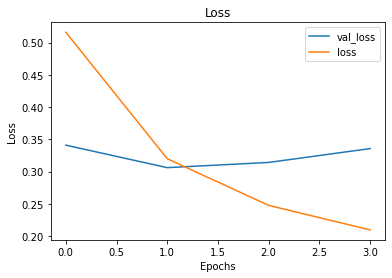

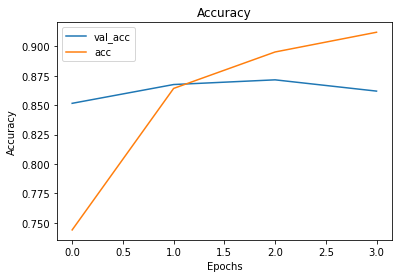

In [60]:
visualize_training_results(results_mlp)